In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
from torchvision.transforms.functional import normalize
from tqdm import tqdm
from torchvision.transforms import v2

from fly_dataset import FLY_Dataset
from fly_resnet import FLY_Resnet  # oder dein Modell
from fly_training_bumblebee import train_keypoint_model  # deine Trainingsfunktion
from fly_helpers import visualize_fly

# Pfad zum Datensatz
DATA_PATH = "/scratch/cv-course2025/group2/data"

In [2]:
def predict_keypoints(model, dataset, device="cuda", n_samples = 5):
    model = model.to(device)
    model.eval()

    all_preds = []
    all_gts = []
    all_vis = []
    all_imgs = []

    with torch.no_grad():
        for i in range (n_samples):
            img, keypoints, visible = dataset[i]
            img = img.unsqueeze(0).to(device)  # [1, 3, H, W]

            preprocess = ResNet50_Weights.DEFAULT.transforms()
            img = preprocess(img[0].cpu()).unsqueeze(0).to(device)

            pred = model(img)[0].cpu()  # [J, 2]

            all_preds.append(pred)
            all_gts.append(keypoints)
            all_vis.append(visible)
            all_imgs.append(img[0].cpu())

    return all_imgs, all_preds, all_gts, all_vis


In [3]:
# Dataset laden
train_dataset = FLY_Dataset(DATA_PATH, mode="training", backbone="resnet")
test_dataset = FLY_Dataset(DATA_PATH, mode="test", backbone="resnet")

# Modell initialisieren
model = FLY_Resnet(num_joints=38)

# CUDA/CPU auswählen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Training starten
trained_model = train_keypoint_model(
    model=model,
    dataset=train_dataset,
    num_epochs=10,
    batch_size=16,
    lr=1e-4,
    device=device
)

In [9]:
trained_model = FLY_Resnet()
trained_model.load_state_dict(torch.load("/scratch/cv-course2025/group2/uzk_cvproject/deep-fly-model-resnet50_20250705-204053.pt"))
trained_model.to(device)

FLY_Resnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

pred done
torch.Size([1, 38, 2])


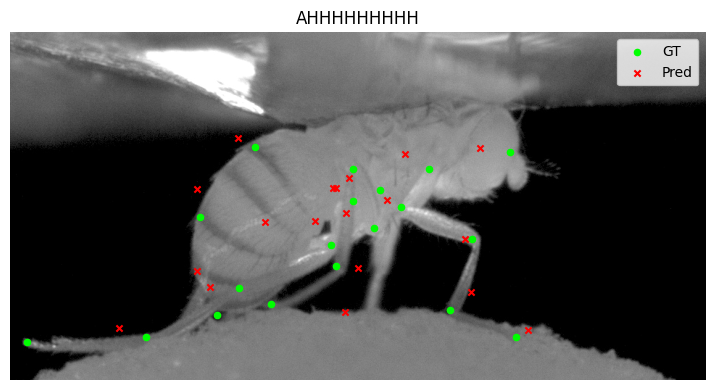

In [20]:
test_img, gt, visible = test_dataset[0]

# 2) Apply your dtype+normalize transforms (still on CPU)
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
])
test_img = transforms(test_img)  # now [3, H, W], float32 on CPU

# 3) Add a batch dim and move to GPU
test_img = test_img.unsqueeze(0).to(device)  # [1, 3, H, W] on CUDA

# 4) Forward pass
with torch.no_grad():
    pred_batch = trained_model(test_img)       # [1, J, 2] on CUDA
pred = pred_batch.cpu().squeeze(0)             # [J, 2] back on CPU


# 🔮 Predictions berechnen
with torch.no_grad():
    pred = trained_model(test_img).cpu()
print("pred done")
print(pred.shape)
# 🖼️ Visualisierung
visualize_fly(image=test_img.cpu().squeeze(0), keypoints_gt=gt, keypoints_pred=pred.squeeze(0), visible=visible, title="AHHHHHHHHH")
